In [ ]:
!pip install node2vec

In [ ]:
import random
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import tensorflow as tf
import math
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from collections import defaultdict
import community
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF


In [ ]:
#!pip install python-louvain

In [ ]:
from prettytable import PrettyTable
import community
import community.community_louvain as louvain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the Dataset**

In [ ]:
rating_complete = pd.read_csv("/content/drive/MyDrive/network science/rating_complete.csv")

#I will consider anime that are completed by the user, to have a fair rating

In [ ]:
anime=pd.read_csv("/content/drive/MyDrive/network science/anime.csv")

In [ ]:
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [ ]:
rating_complete.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [ ]:
rating_complete.shape

(57633278, 3)

In [ ]:
rating_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [ ]:
anime.shape

(17562, 35)

In [ ]:
anime.rename(columns={'MAL_ID': 'anime_id'}, inplace=True)

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   anime_id       17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [ ]:
anime_data = pd.merge(rating_complete, anime[['anime_id', 'Name', 'Genres']], on='anime_id', how='inner')

In [ ]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   anime_id  int64 
 2   rating    int64 
 3   Name      object
 4   Genres    object
dtypes: int64(3), object(2)
memory usage: 2.1+ GB


In [ ]:
anime_data.shape


(57633278, 5)

In [ ]:
anime_data.head()


,user_id,anime_id,rating,Name,Genres
0,0,430,9,Fullmetal Alchemist: The Conqueror of Shamballa,"Military, Comedy, Historical, Drama, Fantasy, ..."
1,6,430,8,Fullmetal Alchemist: The Conqueror of Shamballa,"Military, Comedy, Historical, Drama, Fantasy, ..."
2,18,430,10,Fullmetal Alchemist: The Conqueror of Shamballa,"Military, Comedy, Historical, Drama, Fantasy, ..."
3,19,430,8,Fullmetal Alchemist: The Conqueror of Shamballa,"Military, Comedy, Historical, Drama, Fantasy, ..."
4,33,430,4,Fullmetal Alchemist: The Conqueror of Shamballa,"Military, Comedy, Historical, Drama, Fantasy, ..."


**Too many rows I need to sample**

In [ ]:
data = anime_data.sample(frac=0.05, random_state=42)

In [ ]:
data.shape

(2881664, 5)

In [ ]:
# missing values
null_values = data.isnull().sum()

In [ ]:
null_values #no null values

,0
user_id,0
anime_id,0
rating,0
Name,0
Genres,0


In [ ]:
# Check and remove duplicated rows if there are any
data.drop_duplicates(inplace=True)

In [ ]:
data.shape
#No duplicates

(2881664, 5)

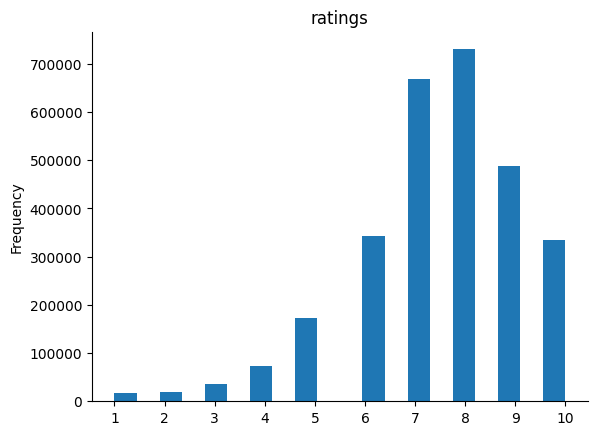

In [ ]:
data['rating'].plot(kind='hist', bins=20, title='ratings')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(ticks=range(1, 11));

In [ ]:
# Filter for liked anime (rating greater than 9 out of 10 by each user).
#That means thatt they have been liked

data_anime = data[data.rating >= 9]
data_anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824109 entries, 41605545 to 37803984
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   824109 non-null  int64 
 1   anime_id  824109 non-null  int64 
 2   rating    824109 non-null  int64 
 3   Name      824109 non-null  object
 4   Genres    824109 non-null  object
dtypes: int64(3), object(2)
memory usage: 37.7+ MB


In [ ]:
data_anime.tail()

,user_id,anime_id,rating,Name,Genres
31735188,138493,4896,9,Umineko no Naku Koro ni,"Mystery, Horror, Psychological, Supernatural"
10621243,207185,17074,9,Monogatari Series: Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"
35377939,164138,33255,10,Saiki Kusuo no Ψ-nan,"Comedy, School, Shounen, Slice of Life, Supern..."
19808785,33012,861,10,xxxHOLiC,"Comedy, Drama, Mystery, Psychological, Superna..."
37803984,313606,33253,9,Ajin 2nd Season,"Action, Horror, Mystery, Seinen, Supernatural"


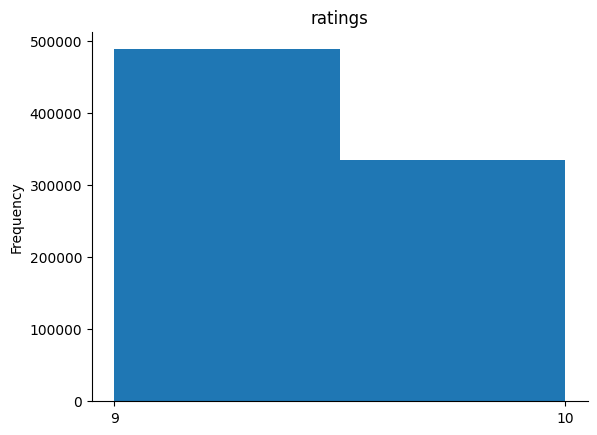

In [ ]:
data_anime['rating'].plot(kind='hist', bins=2, title='ratings')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(ticks=range(9, 11));


## Creating the Graph

In [ ]:
pairs = defaultdict(int)

In [ ]:
#Group by user
for group in data_anime.groupby("user_id"):
    user_anime = list(group[1]["anime_id"])
    for i in range(len(user_anime)):
        for j in range(i+1, len(user_anime)):
            pairs[(user_anime[i], user_anime[j])] += 1  # creating graph


In [ ]:
#Create the graph
G = nx.Graph()

In [ ]:
for pair in pairs:
    anime1, anime2 = pair
    score = pairs[pair]
    if score >= 10:
        # nodes with title
        title1 = data_anime[data_anime.anime_id == anime1].Name.values[0]
        title2 = data_anime[data_anime.anime_id == anime2].Name.values[0]
        G.add_node(anime1, title=title1)
        G.add_node(anime2, title=title2)
        G.add_edge(anime1, anime2, weight=score)

print(G)

Graph with 592 nodes and 10395 edges


## Visualization

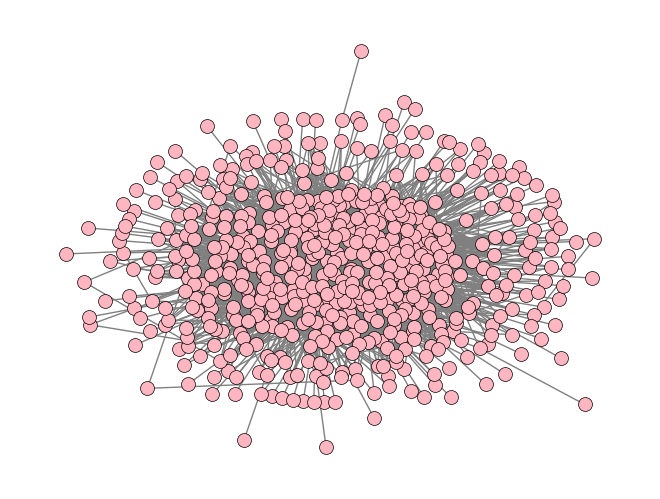

In [ ]:
# visualize the graph
pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos, with_labels=False, font_size=5, node_size=100, node_color='lightpink', font_weight='bold', edge_color='gray', edgecolors='black', linewidths=0.5)

plt.show()

Graph with 592 nodes and 10395 edges


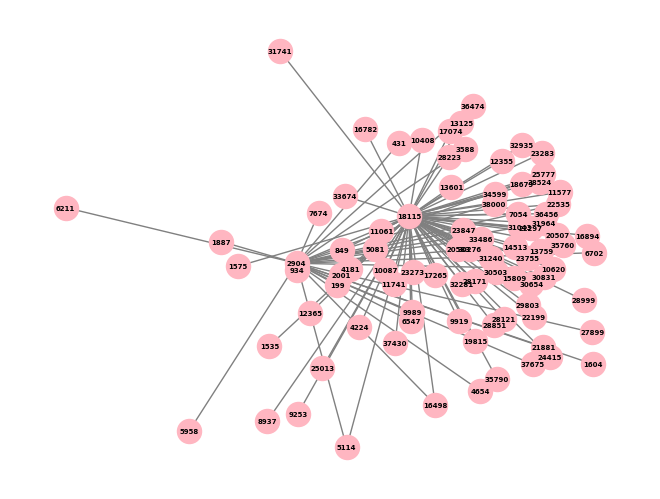

In [ ]:
print(G)
layout = nx.kamada_kawai_layout(G)
subgraph = G.edge_subgraph(list(G.edges())[:100])
nx.draw(subgraph, pos=layout, with_labels=True, font_weight='bold', node_size=300, node_color='lightpink', font_size=5, edge_color='gray')

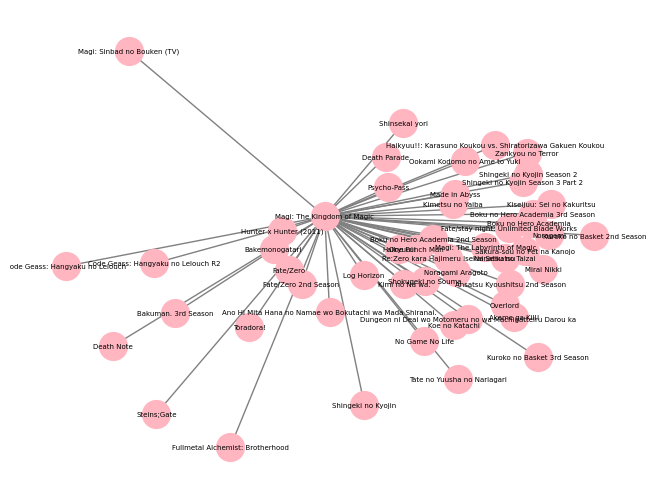

In [ ]:
subgraph = G.edge_subgraph(list(G.edges())[:50])
nx.draw(subgraph, pos, with_labels=False, font_size=5, node_size=400, node_color='lightpink', font_weight='bold', edge_color='gray')

labels = nx.get_node_attributes(subgraph, 'title')
nx.draw_networkx_labels(subgraph, pos, labels, font_size=5)

plt.show()


## Network analysis

In [ ]:
n_nodes = len(G.nodes())
n_edges = len(G.edges())

print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)


Number of nodes: 592
Number of edges: 10395


In [ ]:
degree = G.degree()
degree_list = list(dict(degree).values())

In [ ]:
print("Min Degree:\t{}".format(np.min(degree_list)))
print("Max Degree:\t{}".format(np.max(degree_list)))
print("Mean Degree:\t{:.2f}".format(np.mean(degree_list)))
print("Standard Dev:\t{:.2f}".format(np.std(degree_list)))
print("Median Degree:\t{:.0f}".format(np.median(degree_list)))

Min Degree:	1
Max Degree:	336
Mean Degree:	35.12
Standard Dev:	55.18
Median Degree:	11


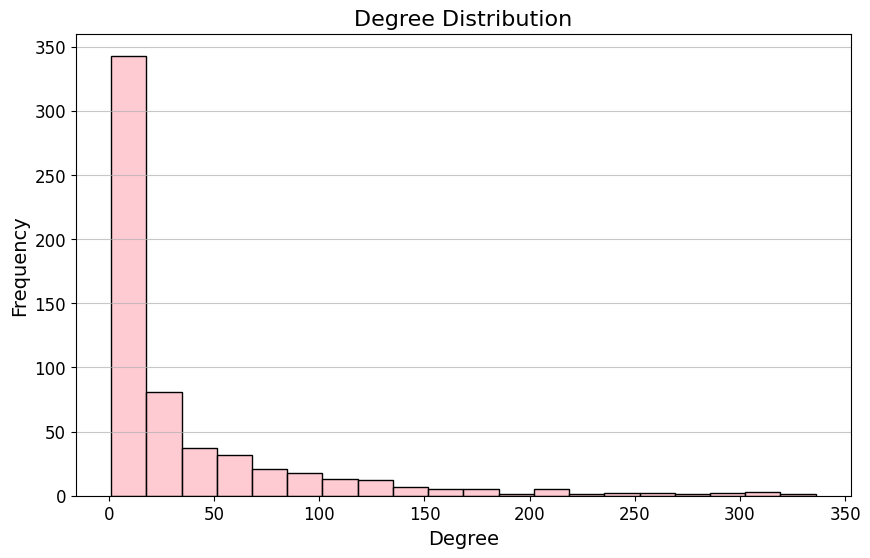

In [ ]:
#Plot the degree distribution

plt.figure(figsize=(10, 6))
sns.histplot(degree_list, bins=20, kde=False, color='lightpink', edgecolor='black', alpha=0.7)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Degree Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

In [ ]:
density = nx.density(G)
density

0.059421731376046096

**ECDF**

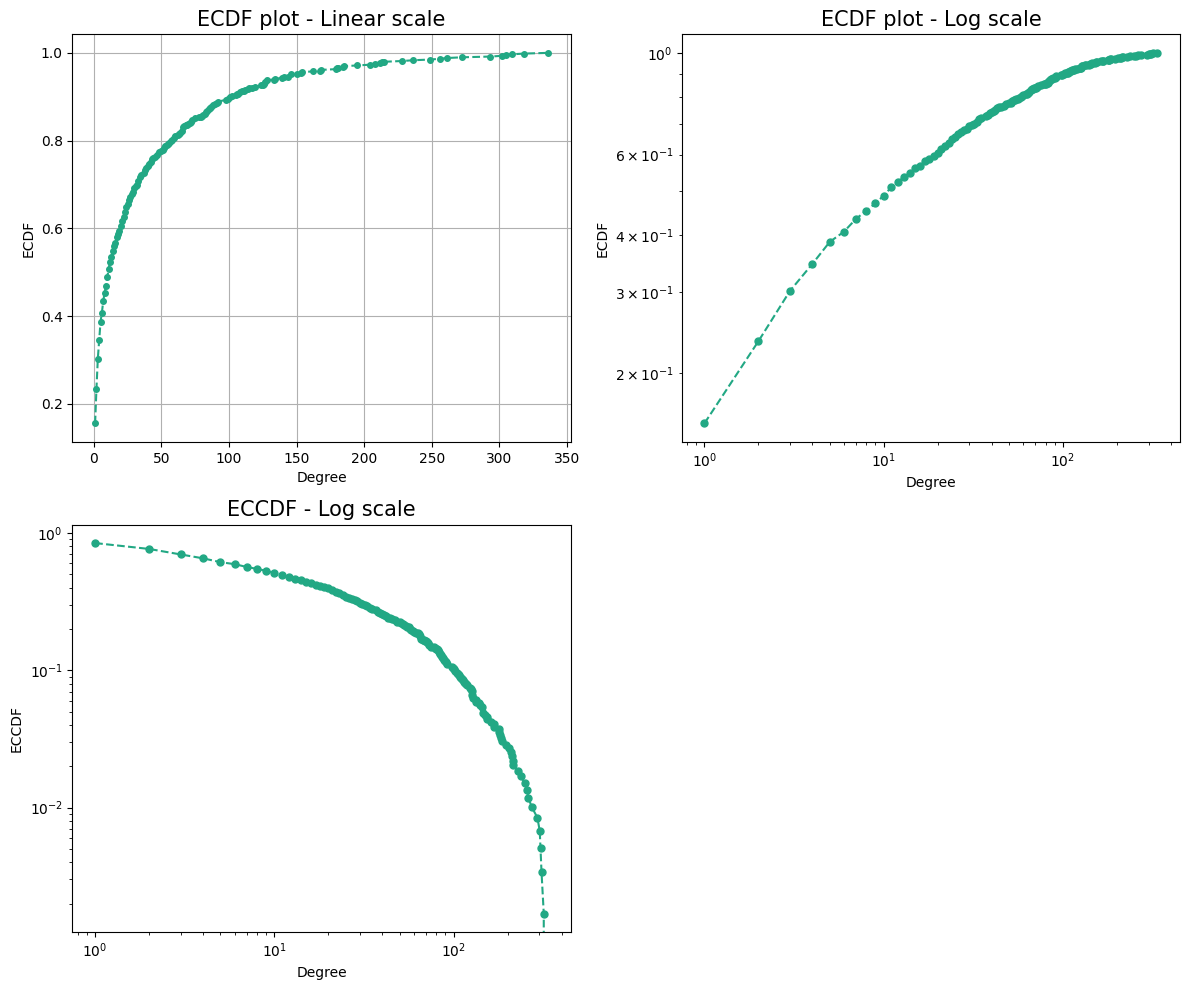

In [ ]:
# Compute ECDF
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)
eccdf_y = 1 - cdf_function(x)

palette = sns.color_palette("viridis", n_colors=4)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot ECDF in linear scale
axs[0, 0].plot(x, y, color=palette[2], linestyle='--', marker='o', ms=4)
axs[0, 0].set_xlabel('Degree', size=10)
axs[0, 0].set_ylabel('ECDF', size=10)
axs[0, 0].set_title("ECDF plot - Linear scale", size=15)
axs[0, 0].grid(True)

# Plot ECDF in log scale
axs[0, 1].loglog(x, y, color=palette[2], linestyle='--', marker='o', ms=5)
axs[0, 1].set_xlabel('Degree', size=10)
axs[0, 1].set_ylabel('ECDF', size=10)
axs[0, 1].set_title("ECDF plot - Log scale", size=15)

# Plot ECCDF in log scale
axs[1, 0].loglog(x, eccdf_y, color=palette[2], linestyle='--', marker='o', ms=5)
axs[1, 0].set_xlabel('Degree', size=10)
axs[1, 0].set_ylabel('ECCDF', size=10)
axs[1, 0].set_title("ECCDF - Log scale", size=15)

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Comparison with a random network

In [ ]:
random_graph = nx.fast_gnp_random_graph(G.order(),density)

print('Numb of nodes:\t{}'.format(random_graph.order()))
print('Numb of links:\t{}'.format(random_graph.size()))
random_degree_list = list(dict(random_graph.degree()).values())

Numb of nodes:	592
Numb of links:	10457


In [ ]:
#Generate a random graph with the same number of nodes and approximately the same number of edges
n_nodes = len(G.nodes)
n_edges = len(G.edges)
p = n_edges / (n_nodes * (n_nodes - 1) / 2)  # Erdős–Rényi model Edge probability

random_graph = nx.erdos_renyi_graph(n_nodes, p)

In [ ]:
#Calculate the degree
random_degrees = dict(random_graph.degree())
random_degree_values = list(random_degrees.values())


In [ ]:
#Calculate the ECDF
random_cdf_funct = ECDF(random_degree_values)
random_eccdf_y = 1 - random_cdf_funct(np.unique(random_degree_values))

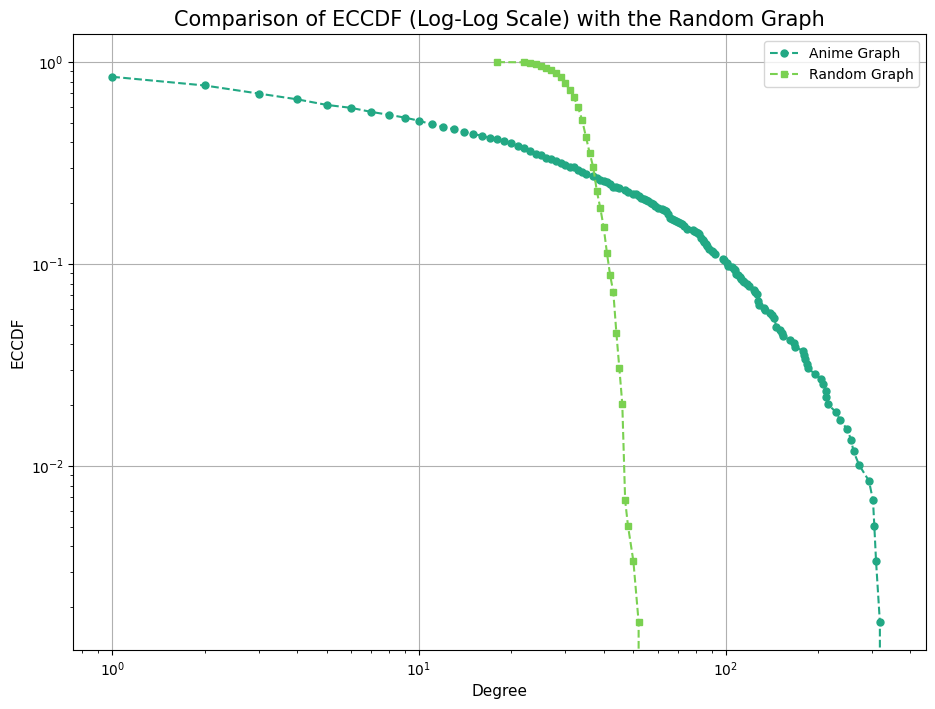

In [ ]:
#Show the plot
plt.figure(figsize=(11, 8))
plt.loglog(x, eccdf_y, color=palette[2], linestyle='--', marker='o', ms=5, label='Anime Graph')

# Plot ECCDFfor rn
plt.loglog(np.unique(random_degree_values), random_eccdf_y, color=palette[3], linestyle='--', marker='s', ms=5, label='Random Graph')

plt.xlabel('Degree', size=11)
plt.ylabel('ECCDF', size=11)
plt.title('Comparison of ECCDF (Log-Log Scale) with the Random Graph', size=15)
plt.legend()
plt.grid(True)
plt.show()


## Centrality

In [ ]:
# degree centrality of the top 3 anime
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_3_degree_centrality = sorted_degree_centrality[:3]
print("\nTop 3 Degree Centrality:")
for node, centrality in top_3_degree_centrality:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Degree Centrality: {centrality:.4f}")


Top 3 Degree Centrality:
Anime: Fullmetal Alchemist: Brotherhood, Degree Centrality: 0.5685
Anime: Steins;Gate, Degree Centrality: 0.5381
Anime: Death Note, Degree Centrality: 0.5228


In [ ]:
#betweenness centrality of the top 3 Anime
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_3_betweenness_centrality = sorted_betweenness_centrality[:3]
print("\nTop 3 Betweenness Centrality:")
for node, centrality in top_3_betweenness_centrality:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Betweenness Centrality: {centrality:.4f}")


Top 3 Betweenness Centrality:
Anime: Fullmetal Alchemist: Brotherhood, Betweenness Centrality: 0.1032
Anime: Steins;Gate, Betweenness Centrality: 0.0821
Anime: Code Geass: Hangyaku no Lelouch, Betweenness Centrality: 0.0763


In [ ]:
#Closeness centrality of the top 3 Anime
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
top_3_closeness_centrality = sorted_closeness_centrality[:3]
print("\nTop 3 Closeness Centrality:")
for node, centrality in top_3_closeness_centrality:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Closeness Centrality: {centrality:.4f}")


Top 3 Closeness Centrality:
Anime: Fullmetal Alchemist: Brotherhood, Closeness Centrality: 0.6933
Anime: Steins;Gate, Closeness Centrality: 0.6732
Anime: Death Note, Closeness Centrality: 0.6671


In [ ]:
#Eigenvector centrality of the top 3 Anime
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
top_3_eigenvector_centrality = sorted_eigenvector_centrality[:3]
print("\nTop 3 Eigenvector Centrality:")
for node, centrality in top_3_eigenvector_centrality:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Eigenvector Centrality: {centrality:.4f}")


Top 3 Eigenvector Centrality:
Anime: Fullmetal Alchemist: Brotherhood, Eigenvector Centrality: 0.1378
Anime: Steins;Gate, Eigenvector Centrality: 0.1359
Anime: Shingeki no Kyojin, Eigenvector Centrality: 0.1351


**Now I will check the pearson correlation which is very useful for understanding if the distribution of centralities is similar with different centrality measure.**

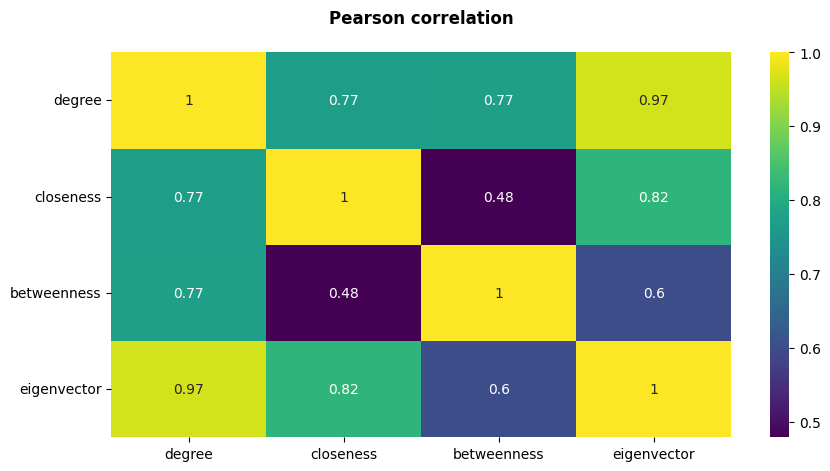

In [ ]:
all_centralities = [degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality]
corr = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centralities] for c2 in all_centralities]
centralities = ['degree', 'closeness','betweenness','eigenvector']

plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corr),annot = True,cmap = 'viridis')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()



## Top 5 hubs

In [ ]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

In [ ]:
degree_dict = dict(G.degree())
sorted_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

top_5_hubs = sorted_degrees[:5]

print("Top 5 Hubs on the anime network for :")
for node, degree in top_5_hubs:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Degree: {degree}")

Top 5 Hubs on the anime network for :
Anime: Fullmetal Alchemist: Brotherhood, Degree: 336
Anime: Steins;Gate, Degree: 318
Anime: Death Note, Degree: 309
Anime: Shingeki no Kyojin, Degree: 305
Anime: Code Geass: Hangyaku no Lelouch R2, Degree: 302


## Connected components and clustering coefficient

In [ ]:
nx.is_connected(G)

False

In [ ]:
numb_cc=nx.number_connected_components(G)
print(numb_cc)

3


In [ ]:
cc= list(nx.connected_components(G))
print(cc)

[{1, 28675, 5, 6, 22535, 34822, 14345, 28677, 12293, 4107, 16, 14353, 19, 20, 24, 20507, 28701, 30, 10271, 32, 33, 36896, 43, 44, 45, 47, 28725, 2104, 57, 4155, 60, 14397, 59, 28735, 66, 12355, 6211, 6213, 71, 72, 73, 18507, 12365, 28755, 4181, 36949, 34902, 4182, 32867, 101, 20583, 30831, 16498, 34933, 4214, 2167, 120, 121, 24701, 12413, 24703, 4224, 14467, 28805, 36999, 136, 137, 138, 10379, 150, 28825, 12445, 164, 32935, 10408, 32937, 14513, 28851, 32949, 32951, 4280, 4282, 2236, 12477, 199, 22729, 202, 2251, 6347, 205, 6351, 16592, 8407, 8408, 32983, 28891, 223, 225, 226, 227, 32995, 32998, 232, 8425, 28907, 237, 239, 18671, 37105, 12531, 245, 35062, 18679, 249, 28927, 35073, 24833, 22789, 263, 268, 269, 270, 37141, 33049, 10521, 39195, 39198, 4382, 35120, 20785, 28977, 20787, 37171, 317, 18753, 16706, 31043, 8516, 28999, 33095, 329, 8525, 339, 37210, 355, 356, 35180, 2418, 4472, 14713, 16762, 376, 10620, 4477, 14719, 392, 33161, 16782, 6547, 14741, 416, 20899, 29093, 29095, 2472, 

In [ ]:
component_sizes = [len(component) for component in components]

print(f"Number of connected components: {len(components)}")

print("Sizes of connected components:")
for i, size in enumerate(component_sizes, 1):
    print(f"Component {i}: {size} nodes")

Number of connected components: 3
Sizes of connected components:
Component 1: 588 nodes
Component 2: 2 nodes
Component 3: 2 nodes


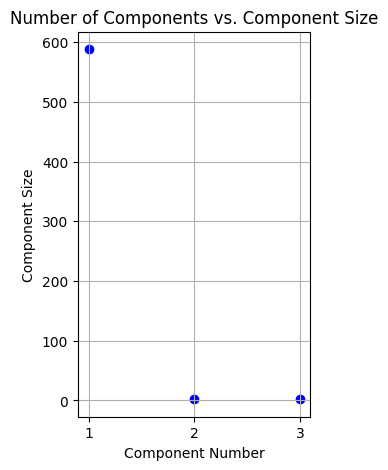

In [ ]:
components = list(nx.connected_components(G))

# Get the number of components and the size of each component
num_components = len(components)
component_sizes = [len(component) for component in components]

# Plot the number of components against the component size
plt.figure(figsize=(3, 5))
plt.scatter(range(1, num_components + 1), component_sizes, color='blue', marker='o')
plt.xlabel('Component Number')
plt.xticks(range(1, num_components + 1))
plt.ylabel('Component Size')
plt.title('Number of Components vs. Component Size')
plt.grid(True)
plt.show()

In [ ]:
larg_cc = max(nx.connected_components(G), key = len)


In [ ]:
larg_cc_graph = G.subgraph(larg_cc)
num_nodes_largest = len(larg_cc_graph.nodes())
num_edges_largest = len(larg_cc_graph.edges())
print("Number of nodes in the largest connected component:", num_nodes_largest)
print("Number of edges in the largest connected component:", num_edges_largest)

Number of nodes in the largest connected component: 588
Number of edges in the largest connected component: 10393


In [ ]:
#diameter of the largest component
diameter = nx.diameter(larg_cc_graph)
print("Diameter:", diameter)

Diameter: 5


One thing that I wanted to check is what are the genres in the largest connected components

In [ ]:
#Extract anime IDs from the largest connected component
anime_ids_lcc = list(larg_cc_graph.nodes())

# Filter the data_anime dataframe to get genres for the anime in the largest connected component
genres_list = []
for anime_id in anime_ids_lcc:
    genres = data_anime[data_anime["anime_id"] == anime_id]["Genres"].values[0]
    genres_split = genres.split(", ")
    genres_list.extend(genres_split)

genre_counts = Counter(genres_list)


print("Genre counts in the largest connected component:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

Genre counts in the largest connected component:
Action: 256
Adventure: 117
Magic: 62
Fantasy: 144
Shounen: 159
Military: 33
Sci-Fi: 108
Super Power: 59
Drama: 206
Mecha: 29
Slice of Life: 109
Supernatural: 181
Comedy: 271
Space: 9
Horror: 29
Mystery: 96
Romance: 192
School: 157
Psychological: 63
Seinen: 63
Police: 9
Thriller: 40
Martial Arts: 11
Game: 26
Parody: 26
Dementia: 9
Historical: 43
Vampire: 23
Demons: 35
Ecchi: 52
Shoujo: 34
Samurai: 16
Harem: 46
Sports: 26
Josei: 12
Music: 20
Cars: 1
Shounen Ai: 2


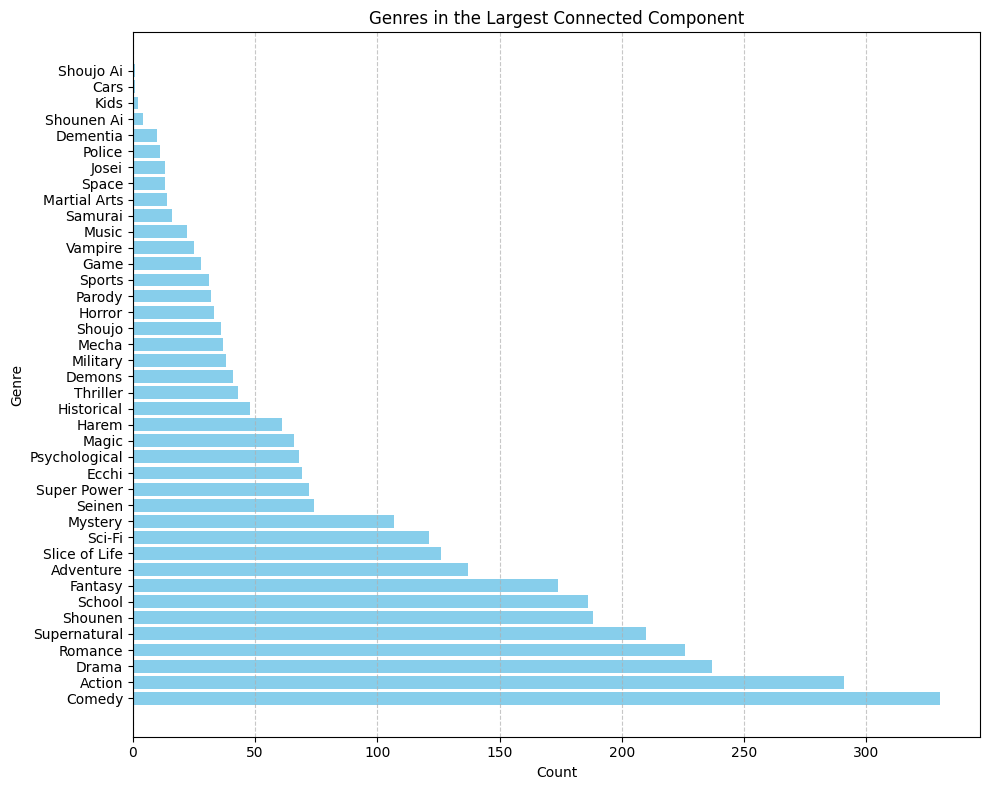

In [ ]:

genre_counts = {
    "Action": 291, "Adventure": 137, "Magic": 66, "Fantasy": 174, "Shounen": 188,
    "Military": 38, "Sci-Fi": 121, "Super Power": 72, "Drama": 237, "Mecha": 37,
    "Slice of Life": 126, "Supernatural": 210, "Comedy": 330, "Space": 13, "Horror": 33,
    "Ecchi": 69, "Mystery": 107, "Romance": 226, "School": 186, "Psychological": 68,
    "Seinen": 74, "Police": 11, "Thriller": 43, "Martial Arts": 14, "Game": 28,
    "Parody": 32, "Dementia": 10, "Historical": 48, "Vampire": 25, "Demons": 41,
    "Samurai": 16, "Shoujo": 36, "Harem": 61, "Sports": 31, "Cars": 1, "Josei": 13,
    "Music": 22, "Shounen Ai": 4, "Shoujo Ai": 1, "Kids": 2
}


sorted_genres = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(10, 8))
plt.barh(list(sorted_genres.keys()), list(sorted_genres.values()), color='skyblue')

plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Genres in the Largest Connected Component')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


In [ ]:
comp_2_nodes = cc[1]
comp_2_names = [G.nodes[node]['title'] for node in comp_2_nodes]
print("Title of animes in Connected Component 2:")
for title in comp_2_names:
    print(title)
print('\n')

comp_3_nodes = cc[2]
comp_3_names = [G.nodes[node]['title'] for node in comp_3_nodes]
print("Title of animes in Connected Component 3:")
for title in comp_3_names:
    print(title)
print('\n')



Title of animes in Connected Component 2:
Junjou Romantica
Junjou Romantica 2


Title of animes in Connected Component 3:
Ajin
Ajin 2nd Season




**Clustering Coefficient**

In [ ]:
clustering_coefficient = nx.average_clustering(G)

print("Average clustering coefficient:", clustering_coefficient)

Average clustering coefficient: 0.6657473062765665


In [ ]:
transitivity = nx.transitivity(G)
print("Global clustering coefficient:", transitivity)

Global clustering coefficient: 0.40354858823332673


**Assortativity**

In [ ]:
assortativity= nx.degree_assortativity_coefficient(G)
print(f"Assortativity of the degree: {assortativity}")

Assortativity of the degree: -0.41356758173469904


**Bridges**

In [ ]:

bridges = list(nx.bridges(G))

total_edges = G.number_of_edges()
percentage_bridges = (len(bridges) / total_edges) * 100

print(f"The Number of bridges: {len(bridges)}")
print(f"The Percentage of bridges: {percentage_bridges:.2f}%")

The Number of bridges: 91
The Percentage of bridges: 0.88%


## Community detection

**Louvain's Communities**

In [ ]:
partition = louvain.best_partition(G)

# Assign the partition as a node attribute named 'community'
nx.set_node_attributes(G, name='community', values=partition)

# Calculate the number of unique communities
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

# Calculate and display the size of each community
community_sizes = Counter(partition.values())

# Print the community sizes
for community_id, size in community_sizes.items():
    print(f"Community {community_id}: Size {size}")

Number of communities: 8
Community 0: Size 171
Community 2: Size 262
Community 3: Size 101
Community 6: Size 42
Community 5: Size 10
Community 1: Size 2
Community 4: Size 2
Community 7: Size 2


In [ ]:
# Display communities with book titles
communities = defaultdict(list)
for node, community_id in partition.items():
    title = G.nodes[node]['title']
    communities[community_id].append(title)

for community_id, anime_name in communities.items():
    print(f"Community {community_id}: {anime_name}")

Community 0: ['Magi: The Kingdom of Magic', 'Boku dake ga Inai Machi', 'Shingeki no Kyojin Season 2', 'Koe no Katachi', 'Naruto', 'Overlord', 'Boku no Hero Academia', 'Hataraku Maou-sama!', 'Steins;Gate 0', 'Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen', 'Nanatsu no Taizai: Imashime no Fukkatsu', 'Fate/stay night: Unlimited Blade Works 2nd Season', 'Death Parade', 'Sakura-sou no Pet na Kanojo', 'Kyoukai no Kanata', 'Kiseijuu: Sei no Kakuritsu', 'Haikyuu!! Second Season', 'Mirai Nikki', 'Haikyuu!!', 'Ansatsu Kyoushitsu 2nd Season', 'Boku no Hero Academia 2nd Season', 'Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku', 'Overlord II', 'Shokugeki no Souma', 'Shokugeki no Souma: San no Sara', 'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou', 'Re:Zero kara Hajimeru Isekai Seikatsu', 'Golden Time', 'Violet Evergarden', 'Danshi Koukousei no Nichijou', 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka', 'Made in Abyss', 'Gate: Jieitai Kanochi nite, Kaku

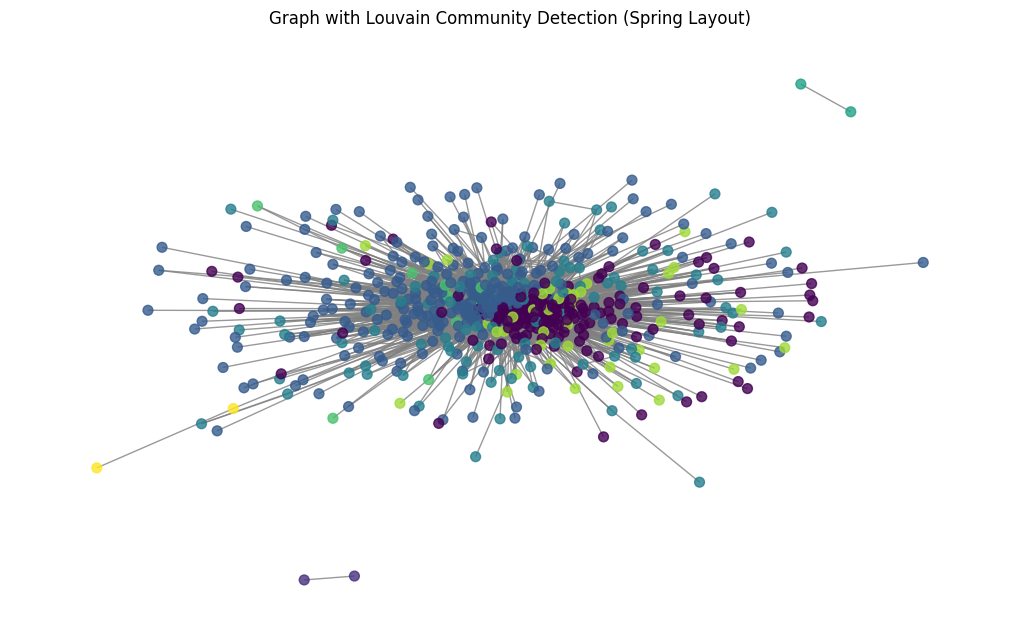

In [ ]:
pos = nx.spring_layout(G, seed=42, k=0.3)  # Adjust seed for reproducibility
plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=50, with_labels=False, node_color=[partition[node] for node in G.nodes()],
        cmap=plt.cm.viridis, font_size=8, edge_color='gray', alpha=0.8)
plt.title('Graph with Louvain Community Detection (Spring Layout)')
plt.show()

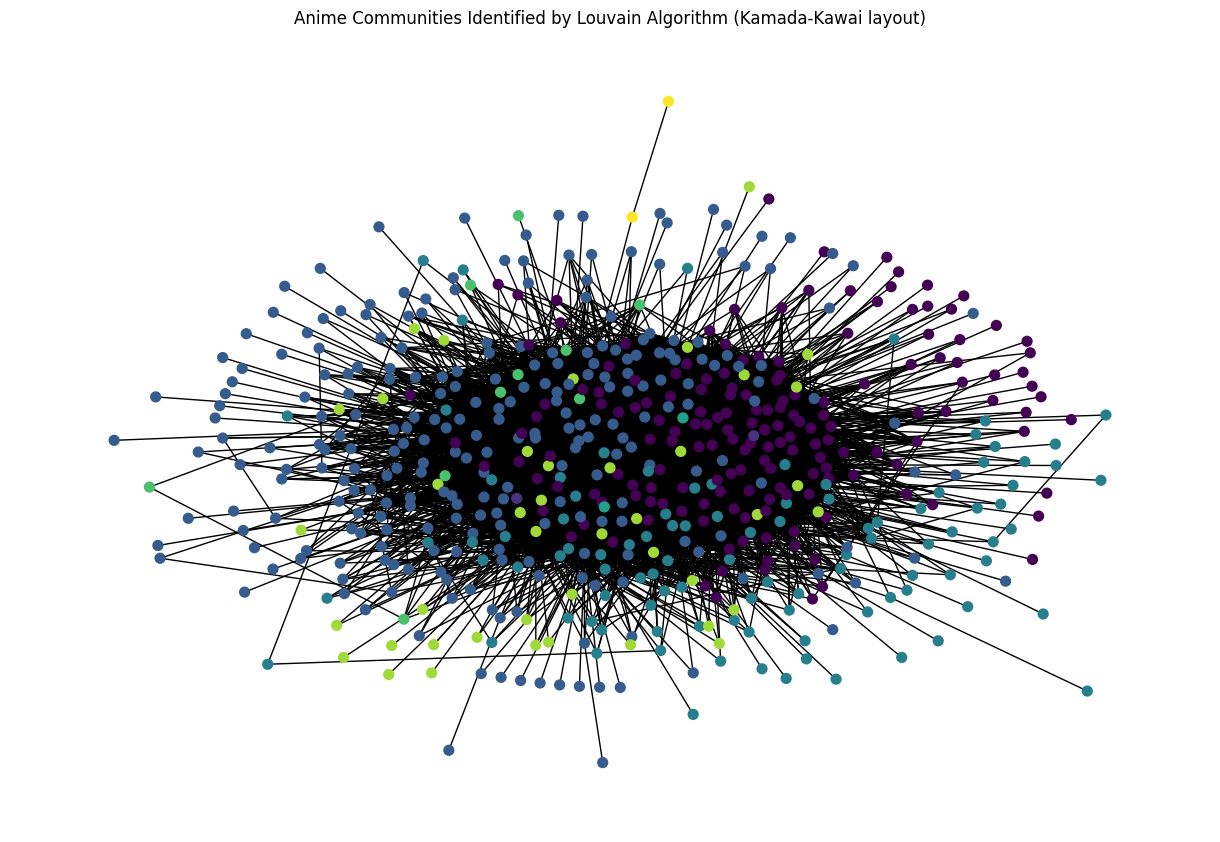

In [ ]:
# Visualize the graph using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)
colors = [partition[node] for node in G.nodes]
plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_size=50, node_color=colors, cmap=plt.cm.viridis, with_labels=False)

plt.title("Anime Communities Identified by Louvain Algorithm (Kamada-Kawai layout)")
plt.show()

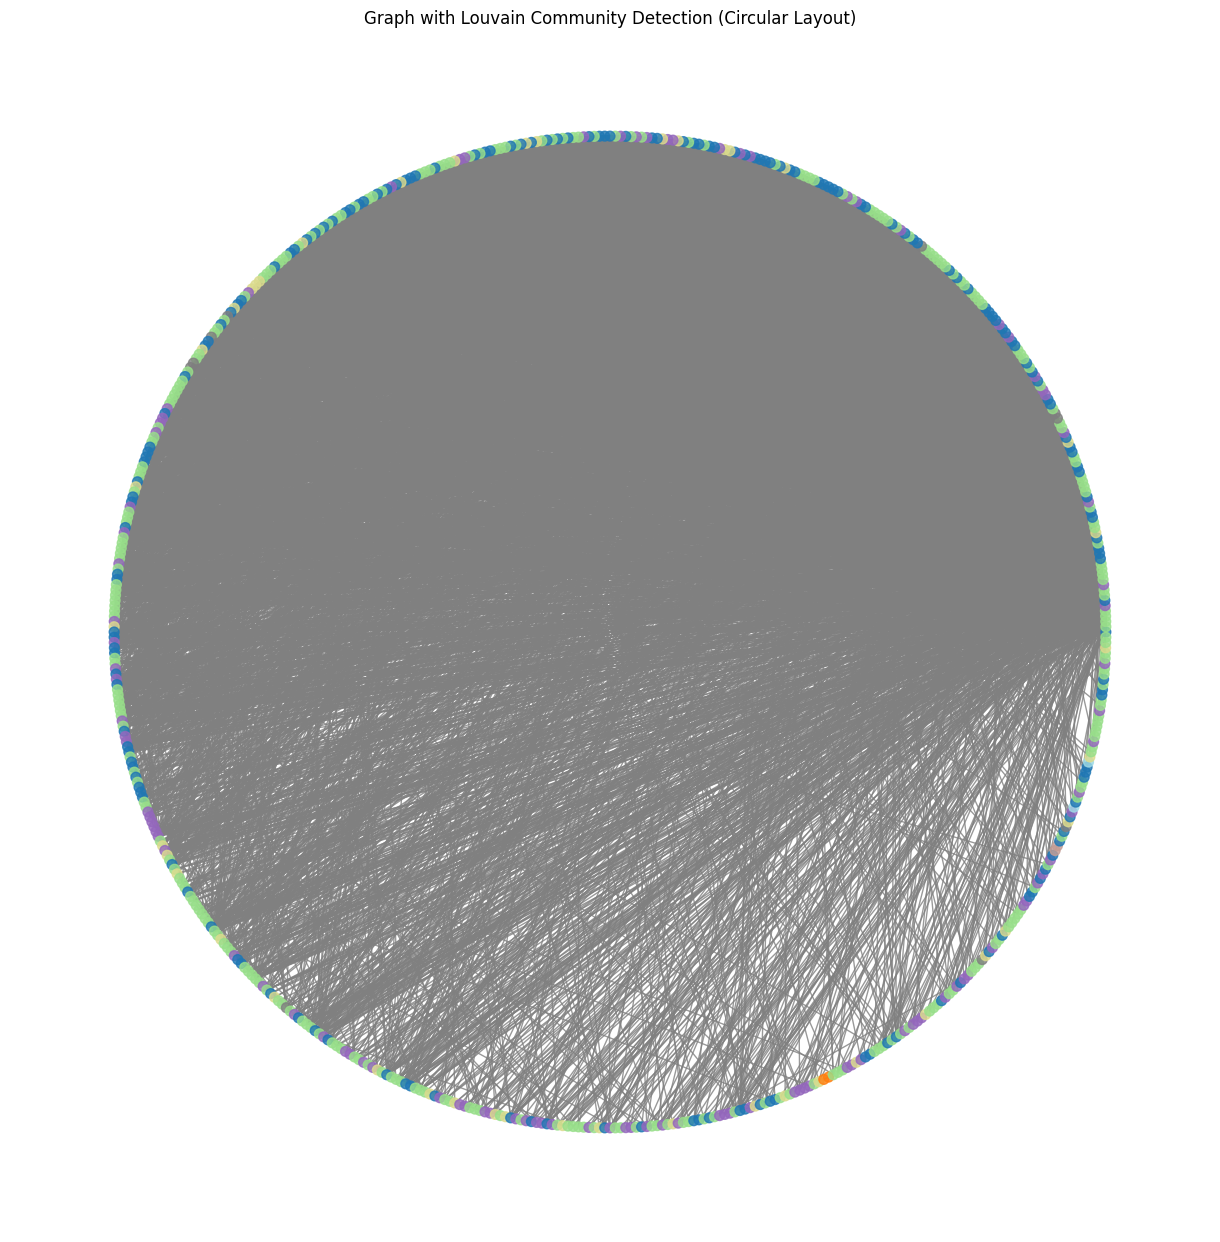

In [ ]:
pos = nx.circular_layout(G)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=False, node_color=[partition[node] for node in G.nodes()],
        cmap=plt.get_cmap('tab20'), node_size=50, font_size=8, edge_color='gray', alpha=0.8)
plt.title('Graph with Louvain Community Detection (Circular Layout)')
plt.show()


**Analyze the Modularity Score:**
The modularity score helps understand the strength of the community structure in the network. A higher score indicates a strong community structure.


In [ ]:
num_communities = len(set(partition.values()))
print("Number of communities:", num_communities)

modularity = louvain.modularity(partition, G)
print("Modularity of the partition:", modularity)

Number of communities: 8
Modularity of the partition: 0.15800705041443203


In [ ]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Select the top 5 nodes
top_5_degree_centrality = sorted_degree_centrality[:5]

# Print top 5 nodes and their degree centrality
print("\nTop 5 Degree Centrality:")
for node, centrality in top_5_degree_centrality:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Degree Centrality: {centrality:.4f}")

# Find which community each of these top nodes belongs to
comms_top = []
for node, _ in top_5_degree_centrality:
    community_id = partition.get(node, 'Unknown')
    comms_top.append((node, community_id))

# Print communities for the top 5 nodes
print("\nCommunities of Top 5 Nodes:")
for node, community_id in comms_top:
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Community ID: {community_id}")



Top 5 Degree Centrality:
Anime: Fullmetal Alchemist: Brotherhood, Degree Centrality: 0.5685
Anime: Steins;Gate, Degree Centrality: 0.5381
Anime: Death Note, Degree Centrality: 0.5228
Anime: Shingeki no Kyojin, Degree Centrality: 0.5161
Anime: Code Geass: Hangyaku no Lelouch R2, Degree Centrality: 0.5110

Communities of Top 5 Nodes:
Anime: Fullmetal Alchemist: Brotherhood, Community ID: 2
Anime: Steins;Gate, Community ID: 6
Anime: Death Note, Community ID: 2
Anime: Shingeki no Kyojin, Community ID: 3
Anime: Code Geass: Hangyaku no Lelouch R2, Community ID: 2


In [ ]:
#average similarity between directly or indirectly connected animes
average_similarity = nx.average_neighbor_degree(G)
print(average_similarity)


{18115: 141.40277777777777, 2904: 62.22516556291391, 9989: 81.24056603773585, 1: 97.80597014925372, 10087: 95.03571428571429, 12445: 199.57142857142858, 31043: 91.50837988826815, 1535: 61.48220064724919, 813: 161.47169811320754, 11757: 84.8586956521739, 199: 77.48356807511738, 227: 155.8846153846154, 3901: 213.92857142857142, 5114: 57.351190476190474, 25777: 102.8082191780822, 28851: 79.86046511627907, 20: 131.08333333333334, 5081: 89.31491712707182, 29803: 132.73417721518987, 9253: 60.040880503144656, 431: 111.46491228070175, 3588: 141.57575757575756, 31964: 96.05555555555556, 15809: 125.0111111111111, 5630: 175.79310344827587, 6547: 70.42578125, 30484: 176.62857142857143, 1889: 165.2, 934: 145.0701754385965, 121: 120.6195652173913, 801: 152.28571428571428, 37999: 128.40963855421685, 34577: 181.14285714285714, 1210: 150.24074074074073, 3652: 309.0, 28701: 137.97674418604652, 28223: 114.4873949579832, 11597: 120.82352941176471, 13759: 97.05479452054794, 20787: 177.5, 11111: 137.2394366

In [ ]:
# Calculate degree for each node
degree_sequence = [degree for node, degree in G.degree()]

# Create a degree distribution dictionary
degree_distribution = {}
for degree in degree_sequence:
    if degree in degree_distribution:
        degree_distribution[degree] += 1
    else:
        degree_distribution[degree] = 1

# Print degree distribution values
print("Degree Distribution:")
for degree, count in degree_distribution.items():
    print(f"Degree: {degree}, Count: {count}")


Degree Distribution:
Degree: 72, Count: 2
Degree: 302, Count: 1
Degree: 212, Count: 1
Degree: 134, Count: 1
Degree: 168, Count: 1
Degree: 14, Count: 7
Degree: 179, Count: 1
Degree: 309, Count: 1
Degree: 53, Count: 2
Degree: 184, Count: 1
Degree: 213, Count: 1
Degree: 26, Count: 6
Degree: 336, Count: 1
Degree: 146, Count: 3
Degree: 215, Count: 1
Degree: 84, Count: 2
Degree: 181, Count: 1
Degree: 79, Count: 1
Degree: 318, Count: 1
Degree: 114, Count: 1
Degree: 66, Count: 5
Degree: 162, Count: 1
Degree: 90, Count: 1
Degree: 29, Count: 3
Degree: 256, Count: 1
Degree: 35, Count: 3
Degree: 40, Count: 2
Degree: 57, Count: 3
Degree: 92, Count: 2
Degree: 7, Count: 16
Degree: 83, Count: 3
Degree: 54, Count: 2
Degree: 1, Count: 92
Degree: 86, Count: 2
Degree: 119, Count: 1
Degree: 85, Count: 2
Degree: 10, Count: 11
Degree: 71, Count: 1
Degree: 75, Count: 3
Degree: 39, Count: 3
Degree: 30, Count: 5
Degree: 236, Count: 1
Degree: 47, Count: 2
Degree: 153, Count: 1
Degree: 33, Count: 5
Degree: 34, Co

In [ ]:
# Identify central animes (hubs) that are particularly similar to many other anime films
anime_centr = [node for node, degree in G.degree if degree > 60]

In [ ]:
anime_sorted_by_simil = sorted(average_similarity.items(), key=lambda x: x[1], reverse=True)

# Print the top 5 animes with highest average similarity
top_n_anime_simil = 5
print("\nTop Animes by Average Similarity:")
for i, (node, similarity) in enumerate(anime_sorted_by_simil[:top_n_anime_simil]):
    title = G.nodes[node]['title']
    print(f"Anime: {title}, Average Similarity: {similarity:.2f}")


Top Animes by Average Similarity:
Anime: Vampire Hunter D (2000), Average Similarity: 336.00
Anime: Major S1, Average Similarity: 336.00
Anime: Nurarihyon no Mago: Sennen Makyou, Average Similarity: 336.00
Anime: Quanzhi Gaoshou, Average Similarity: 336.00
Anime: Tengen Toppa Gurren Lagann Movie 1: Gurren-hen, Average Similarity: 336.00


## RecSys with Node2Vec

In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=5, workers=1)

Computing transition probabilities:   0%|          | 0/592 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


In [ ]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
def recommend(anime_title):

    id_anime_entry = data_anime[data_anime['Name'] == anime_title]['anime_id']
    id_anime = str(id_anime_entry.values[0])

    if id_anime in model.wv.key_to_index:
        # Get 5 most similar - word embedding
        similar_anime = model.wv.most_similar(id_anime, topn=5)

        titles = []

        for id, similarity in similar_anime:
            recommended_title = data_anime[data_anime['anime_id'] == int(id)]['Name'].values[0]

            if recommended_title.lower() != anime_title.lower() and recommended_title.lower() not in titles:
                print(f'{recommended_title}: {similarity:.2f}')

                titles.append(recommended_title.lower())

                if len(titles) == 5:
                    break


In [ ]:
recommend('Death Note')

xxxHOLiC: 0.72
Chrno Crusade: 0.71
Higurashi no Naku Koro ni Rei: 0.70
Kaze ga Tsuyoku Fuiteiru: 0.67
Sekaiichi Hatsukoi: 0.66


In [ ]:
recommend("Ajin 2nd Season")

Ajin: 1.00
Haikyuu!! Second Season: 0.49
Re:Zero kara Hajimeru Isekai Seikatsu: 0.49
Tengen Toppa Gurren Lagann Movie 1: Gurren-hen: 0.47
Fullmetal Alchemist: Brotherhood: 0.46


In [ ]:
recommend("Naruto")

Naruto: Shippuuden: 0.60
Kuroko no Basket 3rd Season: 0.55
Naruto: Shippuuden Movie 6 - Road to Ninja: 0.55
Mirai Nikki: 0.54
Tokyo Ghoul: 0.53
